In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive/기계학습/팀프로젝트

Mounted at /content/drive/
/content/drive/MyDrive/기계학습/팀프로젝트


In [2]:
import pandas as pd

player_stat_data = pd.read_csv('cleaned_nba_data__2_.csv')
player_stat_data.head()

,name,debut,start,end,salary,birth,target,Pos,G,GS,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,age
0,A.J. Lawson,2021,2023,2026,1978006.0,2000,0.013971,SG,51.000000,0.000000,...,0.361389,0.970833,1.332222,0.214306,0.126806,0.029167,0.224444,0.648750,3.580139,23
1,Aaron Brooks,2007,2015,2015,2250000.0,1985,0.032143,PG,110.666667,16.031971,...,0.409023,1.395226,1.806451,2.857377,0.659133,0.194449,1.606233,2.030529,9.233652,30
2,Aaron Brooks,2007,2016,2016,2700000.0,1985,0.028680,PG,98.333333,9.805556,...,0.430093,1.373843,1.803935,3.004861,0.603472,0.156713,1.573843,2.073611,9.228935,31
3,Aaron Brooks,2007,2017,2017,2116955.0,1985,0.021363,PG,72.000000,7.000000,...,0.333333,1.200000,1.533333,2.566667,0.500000,0.133333,1.366667,1.866667,7.900000,32
4,Aaron Brooks,2007,2014,2014,1145685.0,1985,0.018167,PG,125.000000,13.547956,...,0.413535,1.292839,1.709676,2.686065,0.638699,0.191673,1.459349,1.895794,8.050478,29


In [3]:
from sklearn.svm import SVR
import joblib

best_model = joblib.load('./best_svr.pkl')

In [4]:
from sklearn.preprocessing import StandardScaler

#데이터 전처리
player_stat_data = player_stat_data.drop(columns=['name','debut','start','end','salary','birth'])

player_stat_data['Pos'] = player_stat_data['Pos'].str.split('-').str[0]
player_stat_data = pd.get_dummies(player_stat_data, columns=['Pos'])

#정규화
scaler = StandardScaler()
player_stat_data['target'] = scaler.fit_transform(player_stat_data[['target']])

player_stat_data.head()

,target,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,BLK,TOV,PF,PTS,age,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,-0.615446,51.000000,0.000000,7.267778,1.429861,2.921250,0.492089,0.566806,1.547083,0.349722,...,0.029167,0.224444,0.648750,3.580139,23,False,False,False,False,True
1,-0.388931,110.666667,16.031971,21.136701,3.364762,8.025476,0.422415,1.241304,3.254127,0.381653,...,0.194449,1.606233,2.030529,9.233652,30,False,False,True,False,False
2,-0.432099,98.333333,9.805556,20.242361,3.367593,8.295602,0.407405,1.273380,3.310417,0.377512,...,0.156713,1.573843,2.073611,9.228935,31,False,False,True,False,False
3,-0.523301,72.000000,7.000000,17.633333,2.933333,7.133333,0.408333,1.066667,2.833333,0.373000,...,0.133333,1.366667,1.866667,7.900000,32,False,False,True,False,False
4,-0.563147,125.000000,13.547956,20.205051,2.947144,7.038214,0.423122,1.111956,2.981191,0.378980,...,0.191673,1.459349,1.895794,8.050478,29,False,False,True,False,False


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

train_X, test_X, train_y, test_y = train_test_split(player_stat_data.drop(columns=['target']), player_stat_data['target'], test_size=0.1)

best_model.fit(train_X, train_y)
prediction = best_model.predict(test_X)
model_r2_score = r2_score(test_y, prediction)
print(model_r2_score)


0.7456545013908809


<ipython-input-6-fdea26da4b99>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_correlations, y=best_feature, palette='viridis')


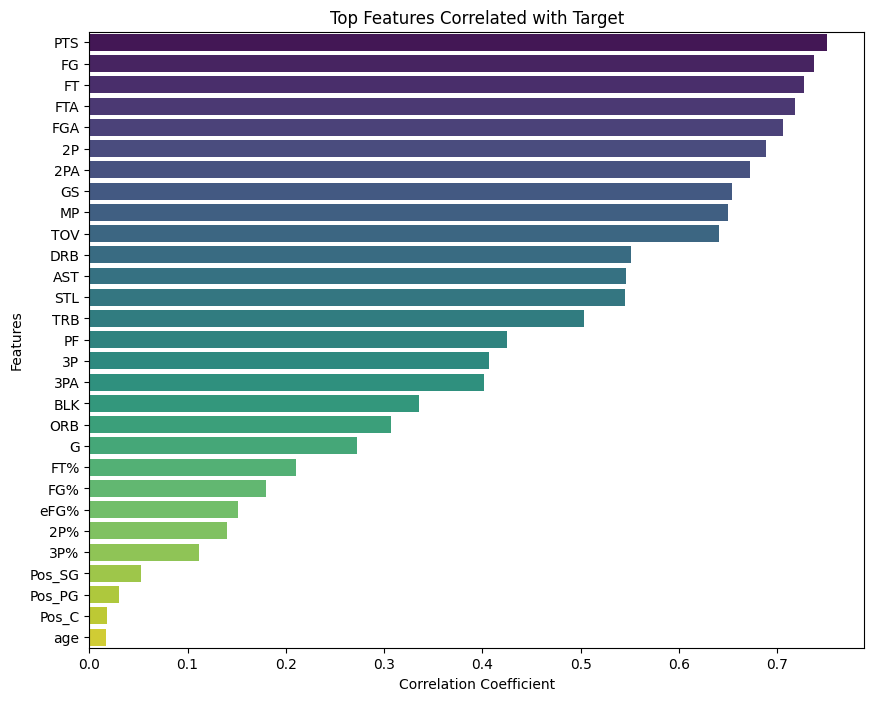

Top 29 Features R2 Score: 0.7343032129141234


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


correlation_matrix = player_stat_data.corr()
target_correlations = correlation_matrix['target'].drop('target')
sorted_correlations = target_correlations.abs().sort_values(ascending=False)

best_r2_score = 0
best_N = 0
best_feature = None
target_length = len(target_correlations.tolist()) + 1
for N in range(1, target_length):
    top_N_features = sorted_correlations.head(N).index

    top_N_feature_data = player_stat_data[top_N_features]
    train_X, test_X, train_y, test_y = train_test_split(top_N_feature_data, player_stat_data['target'], test_size=0.1, random_state=42)

    best_model.fit(train_X, train_y)
    test_predictions = best_model.predict(test_X)

    r2 = r2_score(test_y, test_predictions)
    if r2 > best_r2_score:
        best_r2_score = r2
        best_N = N
        best_feature = top_N_features

# best_feature에 해당하는 상위 N개의 상관계수 값을 가져옵니다.
top_correlations = sorted_correlations[best_feature]

plt.figure(figsize=(10, 8))
sns.barplot(x=top_correlations, y=best_feature, palette='viridis')
plt.title('Top Features Correlated with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

print(f"Top {best_N} Features R2 Score: {best_r2_score}")